# **RegNet**

[Paper](https://arxiv.org/pdf/2101.00590.pdf)

### Modules

In [ ]:
import glob
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import math
import tensorflow as tf
# tf.enable_eager_execution()
# tf.compat.v1.enable_eager_execution()
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import (Input,Conv1D,Conv2D,Dropout, Dense,Reshape,BatchNormalization,Activation,
                                         GlobalAveragePooling2D,GlobalAveragePooling1D, GlobalMaxPooling2D,
                                         MaxPooling2D, Multiply, Add, Permute,Concatenate,Softmax,DepthwiseConv2D,
                                         ZeroPadding2D)
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.regularizers import l2

In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]
    
def cosine_similarity(x, y):
    """
    Compute cosine similarity between samples in x and y.
    Cosine similarity, or the cosine kernel, computes similarity as the
    normalized dot product of x and y:

    K(X, Y) = <X, Y> / (||X||*||Y||)
    """
    dot = sum(a*b for a, b in zip(x, y))
    norm_a = sum(a*a for a in x) ** 0.5
    norm_b = sum(b*b for b in y) ** 0.5

    return dot / (norm_a * norm_b)

### Data

In [ ]:
%%capture 
#Simply adding &> /dev/null to the tail of any command will silence its output outside of any errors that may arise.
!unzip /content/cell_classification_data.zip && rm /content/cell_classification_data.zip

In [ ]:
cell = glob.glob('/content/cell/*.tif')
cell.sort(key=natural_keys)
not_cell = glob.glob('/content/not_cell/*.tif')
not_cell.sort(key=natural_keys)
active_cell = glob.glob('/content/active_cell/*.tif')
active_cell.sort(key=natural_keys)

In [ ]:
X = []
Y = []


for i,j in zip(cell, active_cell):
    im = cv2.imread(i, 1)
    im = cv2.resize(im, (64, 64)) 
    X.append(im)
    Y.append([1])
    im = cv2.imread(j, 1)
    im = cv2.resize(im, (64, 64)) 
    X.append(im)
    Y.append([2])
    if cell.index(i) <= len(not_cell)//2:
        im = cv2.imread(not_cell[cell.index(i)], 1)
        im = cv2.resize(im, (64, 64)) 
        X.append(im)
        Y.append([0])


for i in range(len(cell), len(active_cell), 1):
    im = cv2.imread(active_cell[i], 1)
    im = cv2.resize(im, (64, 64)) 
    X.append(im)
    Y.append([2])

for i in range(len(not_cell)//2, len(not_cell), 1):
    im = cv2.imread(active_cell[i], 1)
    im = cv2.resize(im, (64, 64)) 
    X.append(im)
    Y.append([0])

X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(929, 64, 64, 3)

In [ ]:
Y.shape

(929, 1)

In [ ]:
class_names = ['not_cell', 'cell', 'active_cell']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

### Model

In [ ]:
def get_flops(model):
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.compat.v1.profiler.profile(graph=tf.compat.v1.keras.backend.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.


class Mish(Activation):
    '''
    based on https://github.com/digantamisra98/Mish/blob/master/Mish/TFKeras/mish.py
    Mish Activation Function.
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'

def mish(inputs):
    # with tf.device("CPU:0"):
    result = inputs * tf.math.tanh(tf.math.softplus(inputs))
    return result


class GroupedConv2D(object):
    """Groupped convolution.
    https://github.com/tensorflow/tpu/blob/master/models/official/mnasnet/mixnet/custom_layers.py
    Currently tf.keras and tf.layers don't support group convolution, so here we
    use split/concat to implement this op. It reuses kernel_size for group
    definition, where len(kernel_size) is number of groups. Notably, it allows
    different group has different kernel size.
    """
    def __init__(self, filters, kernel_size, use_keras=True, **kwargs):
        """Initialize the layer.
        Args:
        filters: Integer, the dimensionality of the output space.
        kernel_size: An integer or a list. If it is a single integer, then it is
            same as the original Conv2D. If it is a list, then we split the channels
            and perform different kernel for each group.
        use_keras: An boolean value, whether to use keras layer.
        **kwargs: other parameters passed to the original conv2d layer.
        """
        self._groups = len(kernel_size)
        self._channel_axis = -1

        self._convs = []
        splits = self._split_channels(filters, self._groups)
        for i in range(self._groups):
            self._convs.append(
                self._get_conv2d(splits[i], kernel_size[i], use_keras, **kwargs))

    def _get_conv2d(self,filters, kernel_size, use_keras, **kwargs):
        """A helper function to create Conv2D layer."""
        if use_keras:
            return tf.keras.layers.Conv2D(
                filters=filters, kernel_size=kernel_size, **kwargs)
        else:
            return tf.layers.Conv2D(filters=filters, kernel_size=kernel_size, **kwargs)

    def _split_channels(self,total_filters, num_groups):
        split = [total_filters // num_groups for _ in range(num_groups)]
        split[0] += total_filters - sum(split)
        return split
    
    def __call__(self, inputs):
        if len(self._convs) == 1:
            return self._convs[0](inputs)

        if tf.__version__ < "2.0.0":
            filters = inputs.shape[self._channel_axis].value
        else:
            filters = inputs.shape[self._channel_axis]
        splits = self._split_channels(filters, len(self._convs))
        x_splits = tf.split(inputs, splits, self._channel_axis)
        x_outputs = [c(x) for x, c in zip(x_splits, self._convs)]
        x = tf.concat(x_outputs, self._channel_axis)
        return x



class RegNet():
    """
    RegNet configurations
    """
    def __init__(self, verbose=False, input_shape=(224,224,3), active='relu', n_classes=81,
                dropout_rate=0.2, fc_activation=None, stem_set=48, stage_depth=[2,6,17,2],
                stage_width=[48,120,336,888], stage_G=24,SEstyle_atten="SE", using_cb=False,
                ):
        self.channel_axis = -1 #not for change
        self.verbose = verbose
        self.active = active #default relu
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate
        self.fc_activation = fc_activation

        self.SEstyle_atten = "SE"
        self.stem_set = stem_set
        self.stage_depth = stage_depth
        self.stage_width = stage_width
        self.stage_G = stage_G
        self.using_cb = using_cb #not implement yet
        

    def _squeeze_excite_block(self,input_tensor,ratio=16,input_type='2d'):
        """ Create a channel-wise squeeze-excite block
        Args:
            input_tensor: input Keras tensor
            ratio: number of output filters
        Returns: a Keras tensor
        References
        -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
        """
        filters = getattr(input_tensor, 'shape')[self.channel_axis]
        if input_type == '2d':
            se_shape = (1, 1, filters)
            se = GlobalAveragePooling2D(data_format='channels_last')(input_tensor)
        elif input_type == '1d':
            se_shape = (1, filters)
            se = GlobalAveragePooling1D(data_format='channels_last')(input_tensor)
        else:
            assert 1>2,'squeeze_excite_block unsupport input type {}'.format(input_type)
        se = Reshape(se_shape)(se)
        se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
        # se = Permute((3, 1, 2))(se) #if "channels_first"
        x = Multiply()([input_tensor, se])
        return x

    def _make_attention(self,input_tensor,input_type='2d'):
        x = input_tensor
        if self.SEstyle_atten == 'SE':
            x = self._squeeze_excite_block(x,input_type=input_type)
        return x

    def _make_dropout(self,input_tensor,dropout_range=[0.2,0.4]):
        x = input_tensor
        # if self.training:
        rate = random.uniform(dropout_range[0],dropout_range[1])
        random_seed = random.randint(0,5000)
        x = Dropout(rate, noise_shape=None, seed=random_seed)(x)
        return x

    def _make_stem(self,input_tensor,filters=32,size=(7,7),strides=2,layer_name='input_stem'):
        x = input_tensor
        x = Conv2D(filters,kernel_size =size,strides=strides,
                               padding='same',
                               kernel_initializer='he_normal',
                            #    activation=self.active,
                               use_bias=False,
                               data_format='channels_last',
                               name=layer_name)(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation(self.active)(x)
        return x

    def _make_basic_131_block(self,input_tensor,
                              filters=96,
                              group_kernel_size = [3,3,3],
                              filters_per_group=48,
                              stridess=[1,2,1],
                              layer_name='stage1_block1'):

        x2 = tf.identity(input_tensor)
        if 2 in stridess:
            local_name = layer_name+'_shortcut'
            x2 = Conv2D(filters,kernel_size=(1,1),
                                strides=2,
                                padding='same',
                                kernel_initializer='he_normal',
                                # activation=self.active,
                                use_bias=False,
                                data_format='channels_last',
                                name=local_name)(x2)
            x2 = BatchNormalization(axis=self.channel_axis)(x2)
            x2 = Activation(self.active)(x2)

        x = input_tensor
        local_name = layer_name+'_layer1'
        x = Conv2D(filters,kernel_size =1,
                            strides=stridess[0],
                            padding='same',
                            kernel_initializer='he_normal',
                            # activation=self.active,
                            use_bias=False,
                            data_format='channels_last',
                            name=local_name)(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation(self.active)(x)

        local_name = layer_name+'_layer2'
        x = GroupedConv2D(filters=filters,kernel_size=group_kernel_size,strides=stridess[1],
                          use_keras=True,padding='same',kernel_initializer='he_normal',
                          use_bias=False,data_format='channels_last')(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation(self.active)(x)

        local_name = layer_name+'_layer3'
        x = Conv2D(filters,kernel_size =1,
                            strides=stridess[2],
                            padding='same',
                            kernel_initializer='he_normal',
                            # activation=self.active,
                            use_bias=False,
                            data_format='channels_last',
                            name=local_name)(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation(self.active)(x)

        x = self._make_attention(x,input_type='2d')
        m2 = Add()([x, x2])
        return m2

    def _make_stage(self,
                    input_tensor,
                    n_block=2,
                    block_width=96,
                    group_G=48,
                    layer_name='stage1'):
        x = input_tensor

        #first stride 2 block
        local_name='{}_block{}'.format(layer_name,0)
        x = self._make_basic_131_block(x,
                                  filters=block_width,
                                  filters_per_group=group_G,
                                  stridess=[1,2,1],
                                  layer_name=local_name)
        # if self.verbose: print(local_name,'_out',x.shape)

        for i in range(1,n_block):
            local_name='{}_block{}'.format(layer_name,i)
            x = self._make_basic_131_block(x,
                                      filters=block_width,
                                      filters_per_group=group_G,
                                      stridess=[1,1,1],
                                      layer_name=local_name)
        return x


    def build(self):
        get_custom_objects().update({'mish': Mish(mish)})
        input_sig = Input(shape=self.input_shape)
        x = self._make_stem(input_sig,filters=self.stem_set,size=(3,3),strides=2)
        if self.verbose: print('stem_out',x.shape)

        for i in range(len(self.stage_depth)):
            depth = self.stage_depth[i]
            width = self.stage_width[i]
            group_G = self.stage_G

            local_name = 'Stage{}'.format(i)
            x =self._make_stage(x,n_block=depth,
                                block_width=width,
                                group_G=group_G,
                                layer_name=local_name)
            if self.verbose: print(local_name,'_out',x.shape)

        if self.dropout_rate>0:
            x = Dropout(self.dropout_rate, noise_shape=None)(x)

        concats = GlobalAveragePooling2D(name='avg_pool')(x)
        fc_out = Dense(self.n_classes,kernel_initializer='he_normal', use_bias=False,name='fc_NObias')(concats)
        if self.verbose: print("fc_out:",fc_out.shape)

        if self.fc_activation:
            fc_out = Activation(self.fc_activation)(fc_out)

        model = models.Model(inputs=input_sig, outputs=fc_out)

        if self.verbose: print("RegNet builded with input {}, output{}".format(input_sig.shape,fc_out.shape))
        if self.verbose: print('-------------------------------------------')
        if self.verbose: print('')
        return model

### Train the model

In [ ]:
regnet_model = RegNet(verbose=1, input_shape=(64, 64, 3), n_classes=3)
regnet_model = regnet_model.build()

stem_out (None, 32, 32, 48)
Stage0 _out (None, 16, 16, 48)
Stage1 _out (None, 8, 8, 120)
Stage2 _out (None, 4, 4, 336)
Stage3 _out (None, 2, 2, 888)
fc_out: (None, 3)
RegNet builded with input (None, 64, 64, 3), output(None, 3)
-------------------------------------------



In [ ]:
regnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_stem (Conv2D)             (None, 32, 32, 48)   1296        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 48)   192         input_stem[0][0]                 
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 32, 32, 48)   0           batch_normalization_57[0][0]     
______________________________________________________________________________________________

In [ ]:
regnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
regnet_model.fit(x_train, y_train, steps_per_epoch=30, epochs=55, validation_data=(x_test, y_test)) 

Epoch 1/55
30/30 [==============================] - 49s 244ms/step - loss: 2.4674 - accuracy: 0.6366 - val_loss: 9.2722 - val_accuracy: 0.4247
Epoch 2/55
30/30 [==============================] - 4s 119ms/step - loss: 1.6030 - accuracy: 0.8048 - val_loss: 9.2722 - val_accuracy: 0.4247
Epoch 3/55
30/30 [==============================] - 4s 119ms/step - loss: 1.4029 - accuracy: 0.8197 - val_loss: 8.4987 - val_accuracy: 0.4731
Epoch 4/55
30/30 [==============================] - 4s 119ms/step - loss: 1.5990 - accuracy: 0.7672 - val_loss: 8.4411 - val_accuracy: 0.4785
Epoch 5/55
30/30 [==============================] - 4s 120ms/step - loss: 2.4506 - accuracy: 0.6972 - val_loss: 6.1870 - val_accuracy: 0.5914
Epoch 6/55
30/30 [==============================] - 4s 123ms/step - loss: 1.7599 - accuracy: 0.7618 - val_loss: 5.0239 - val_accuracy: 0.6882
Epoch 7/55
30/30 [==============================] - 4s 123ms/step - loss: 1.2298 - accuracy: 0.8048 - val_loss: 3.4343 - val_accuracy: 0.7634
Epoch

In [ ]:
loss, accuracy = regnet_model.evaluate(x_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

6/6 [==============================] - 0s 51ms/step - loss: 3.0814 - accuracy: 0.6882
Loss: 3.081441879272461
Accuracy: 0.6881720423698425


In [ ]:
random.shuffle(x_test)

In [ ]:
predictions = regnet_model.predict(x_train)

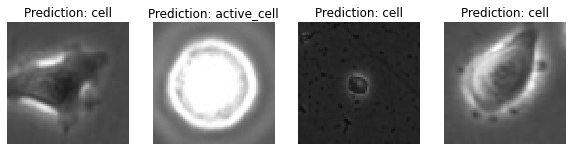

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, x_train, predictions):
    ax.set_axis_off()
    image = image.reshape(64, 64, 3)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {class_names[np.argmax(prediction)]}')

In [ ]:
y_predict = regnet_model.predict(x_test)
y_predict = [np.argmax(predict) for predict in y_predict]
y_true=y_test
res = tf.math.confusion_matrix(y_true,y_predict)

In [ ]:
res

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 0, 27,  1],
       [ 0, 74,  5],
       [ 0, 73,  6]], dtype=int32)>

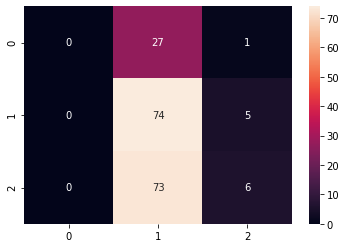

In [ ]:
sns.heatmap(res, annot=True)